In [41]:
from data_helper import *
from topic_analysis import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


/home/yevhen/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [70]:
all_data = load_dump("train_dev_df")


In [115]:
all_posts = all_data.post
ill = all_data[all_data["label"] == 1].post
healthy = all_data[all_data["label"] == 0].post

In [5]:
# plt.bar(clin_ids, clin_len)
# plt.xlabel('Doc', fontsize=5)
# plt.ylabel('Word Counts', fontsize=5)
# plt.axhline(clin_mean[0], color='red')
# plt.ylim(ymax=5000)
# plt.title('Doc length statistics')
# plt.show()

## Topic modelling using LDA

In [117]:
no_features = 100000

In [118]:
vec = CountVectorizer(max_features=no_features)
fit_vec = vec.fit(all_posts)

In [119]:
hi = vec.transform(all_posts)
hlthy = vec.transform(healthy)
illl = vec.transform(ill)

In [120]:
hlthy.shape

(5614, 64344)

In [121]:
vocab = np.array(vec.get_feature_names())

In [122]:
n_topics = 15

In [123]:
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=50,
                                learning_method='batch',
                                random_state=5)
fit_lda = lda.fit(hi)

In [124]:
topic_doc_h = lda.transform(hlthy)
topic_doc_i = lda.transform(illl)

In [125]:
topic_doc_h.shape

(5614, 15)

In [126]:
labels = np.arange(n_topics)

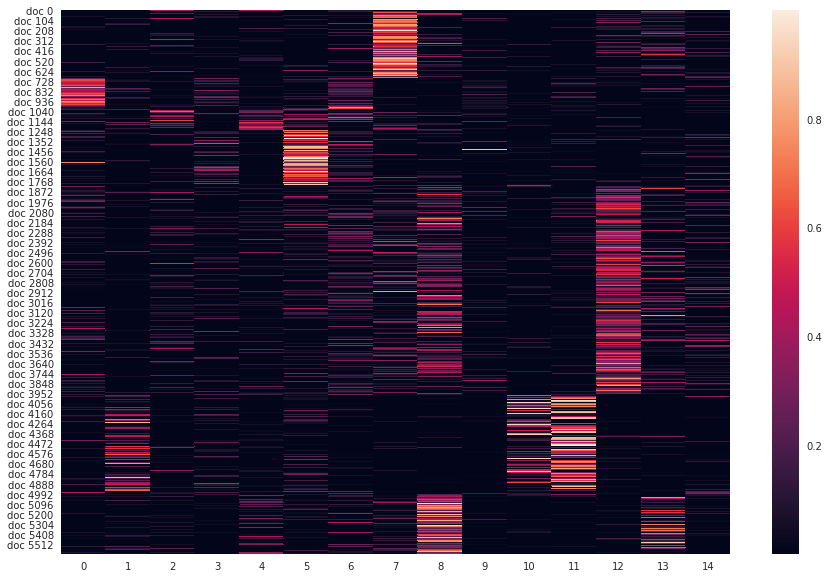

In [127]:
plot_heatmap(topic_doc_h, labels)

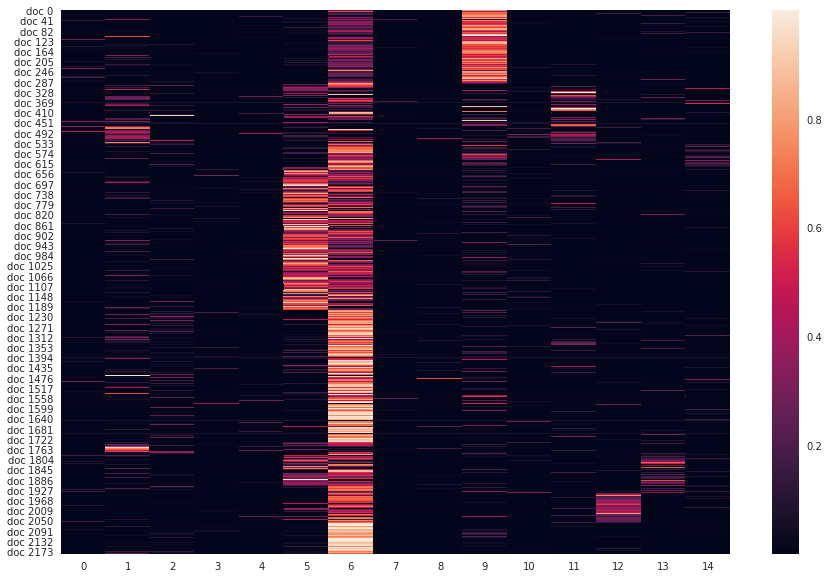

In [128]:
plot_heatmap(topic_doc_dev, labels)

In [129]:
from collections import Counter

In [130]:
def get_doc_top_topics_probs(topic2doc, n, th):

    """

    :param topic2doc: Topic-to-document matrix
    :param n: Top topic probs to be extracted
    :return: Top topics dictionary; key: document index, value: array of topic numbers
    """
    top_topics = []
    dropped_topics = []
    for idx in range(topic2doc.shape[0]):
        topic_idxs = np.argpartition(topic2doc[idx], -n)[-n:]
        # topic_probs = topic2doc[idx][topic_idxs]
        # top_topics_dict[idx] = topic_idxs
        if topic_idxs.item(0) >= th:
            top_topics.append(topic_idxs.item(0))
        else:
            dropped_topics.append(topic2doc[idx])
    print(len(dropped_topics))
    return top_topics

In [131]:
def get_contingency_table(topic2doc_control, topic2doc_clinical):
    control_topics = get_doc_top_topics_probs(topic2doc_control, 1, 0)
    clinical_topics = get_doc_top_topics_probs(topic2doc_clinical, 1, 0)
    ctrl_counts = Counter(control_topics)
    clin_counts = Counter(clinical_topics)
    ctrl_vals = [sorted(ctrl_counts.items())[i][1] for i in range(len(ctrl_counts))]
    clin_vals = [sorted(clin_counts.items())[i][1] for i in range(len(clin_counts))]
    
    sum_row = ctrl_vals+clin_vals
    data = np.array([ctrl_vals, clin_vals])
    index = ["control", "clinical"]
    columns = sorted(ctrl_counts.keys())
    table = pd.DataFrame(data=data, index=index, columns=columns)
    return table


In [132]:
cont_table = get_contingency_table(topic_doc_h, topic_doc_i)
cont_table


0
0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
control,323,260,176,131,104,554,235,740,992,37,240,490,950,261,121
clinical,87,26,587,382,9,1112,1103,17,40,731,2,9,111,37,1290


In [33]:
df = load_dump("train_dev_df")
clinical = df[df["label"] == 1].post
control = df[df["label"] == 0].post
# print(sum(cont_table.loc["control", :]))
# print(sum(cont_table.loc["clinical", :]))

8984
2057


In [24]:
vecc = CountVectorizer(max_features=no_features, min_df=3, max_df=0.8)
fit_vecc = vecc.fit(df["post"])

In [25]:
vec_ctrl = vecc.transform(control).toarray()
vec_clin = vecc.transform(clinical).toarray()

In [46]:
all_vec = vec_ctrl+vec_clin

ValueError: operands could not be broadcast together with shapes (5614,30934) (5543,30934) 

In [26]:
vocab = np.array(vecc.get_feature_names())
print(len(vocab))

30934


In [45]:
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=30,
                                learning_method='batch')
fit_lda = lda.fit(vec_ctrl+vec_clin)

ValueError: operands could not be broadcast together with shapes (5614,30934) (5543,30934) 

In [35]:
topic_doc_ctrl = lda.transform(vec_ctrl)
topic_doc_clin = lda.transform(vec_clin)


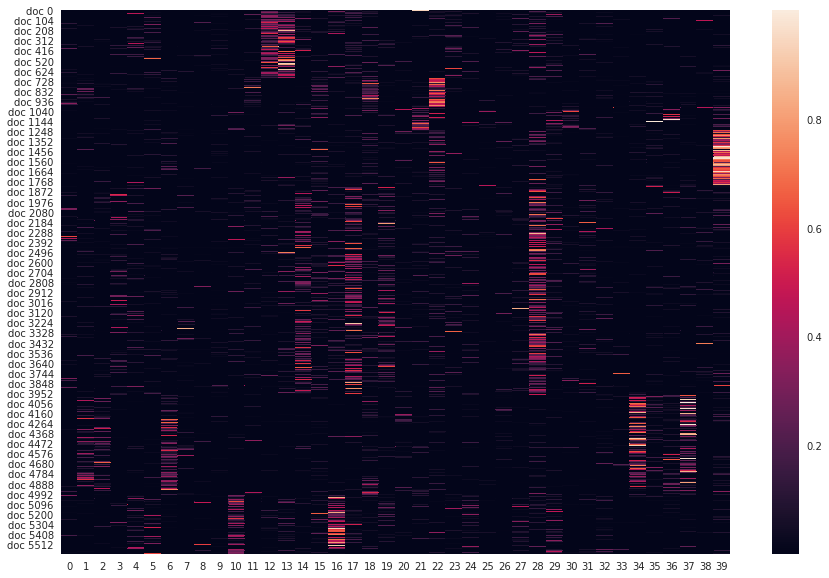

In [42]:
plot_heatmap(topic_doc_ctrl, labels)

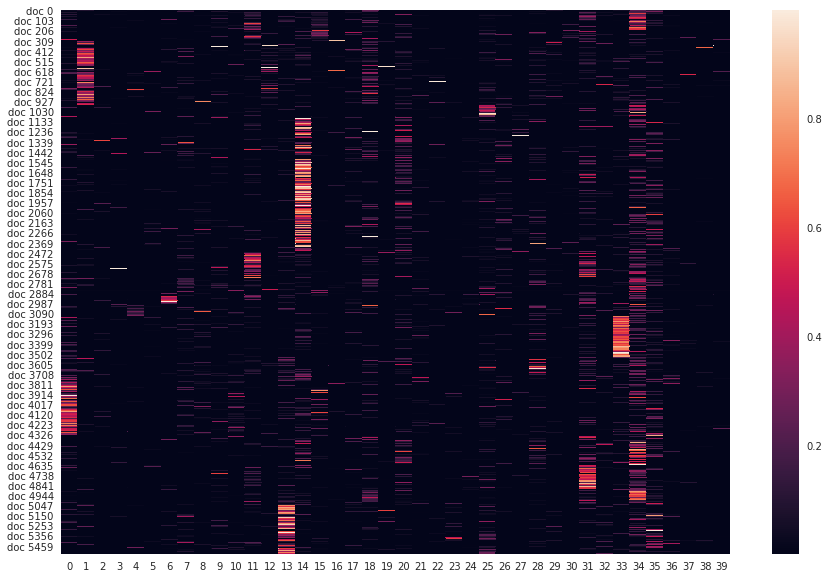

In [44]:
plot_heatmap(topic_doc_clin, labels)

In [36]:
table = get_contingency_table(topic_doc_ctrl, topic_doc_clin)
table

52
383


,1,2,3,4,5,6,7,8,9,10,...,30,31,32,33,34,35,36,37,38,39
control,110,71,106,46,68,192,22,8,4,152,...,52,51,30,15,260,32,74,247,19,537
clinical,464,6,16,21,5,81,54,23,27,59,...,9,414,31,386,876,264,19,12,7,14


In [37]:
print(len(control))
print(sum(table.loc["control", :]))

5614
5562


In [38]:
print(len(clinical))
print(sum(table.loc["clinical", :]))

5543
5160
